# Recognition Parametrized Model (RPM): Peer Supervision


Observations $\mathcal{X} = \{ x_j \}$ are groups of MNIST images representing $J$ different renderings of the same digit. The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

## Load and Rearanged MNIST

In [103]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils_process import plot_loss

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist

from fast_rpm import RPM
import torch.nn.functional as F


data_folder = './../MNIST'

# Load MNIST
train_data = datasets.MNIST(
    root=data_folder,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root=data_folder,
    train=False,
    transform=ToTensor()
)

# Random seeds
torch.manual_seed(10)

# Number of Conditionally independent Factors
num_factors = 2

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits (for efficiency)
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sub_ids = torch.tensor([0, 1, 2, 3])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, 
    train_data.train_labels, 
    num_factors, 
    train_length=train_length,
    sub_ids=sub_ids
)



# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations_test, test_images, test_labels = rearrange_mnist(
    test_data.test_data, 
    test_data.test_labels, 
    num_factors, 
    train_length=test_data.test_labels.shape[0],
    sub_ids=sub_ids
)
test_labels = test_labels.reshape(observations_test[0].shape[0], num_factors)
            

## Move to GPU

In [104]:
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

Jnoise = 1
observations[Jnoise] += 2 * observations[Jnoise].abs().max() * torch.rand(observations[Jnoise].shape)
observations_test[Jnoise] += 2 * observations_test[Jnoise].abs().max() * torch.rand(observations_test[Jnoise].shape)

# Training Move to GPU
obs = [(obsi / obsi.max()).to(device) for obsi in observations]

# Testing Move to GPU
obs_test = [(obsi / obsi.max()).to(device) for obsi in observations_test]


## Typical Observations

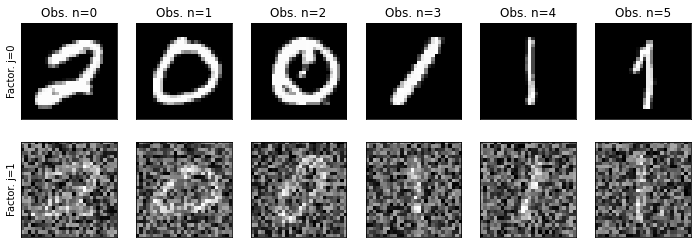

In [105]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(obs[facti][num_plot[obsi], :, :].cpu().numpy(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if facti == 0:
            plt.title('Obs. n=' + str(obsi))
        if obsi == 0:
            plt.ylabel('Factor. j=' + str(facti))

## Fit

In [106]:
# Fit params

factors_params = {
    'channels': [[1, 30, 30, 30], [1, 30, 30, 30]],
    'kernel_conv': [[5, 5, 5], [5, 5, 5]],
    'kernel_pool': [[1, 2, 2], [1, 2, 2]],
    'dim_hidden': [[20, 20], [20, 20]],
    'nonlinearity': [F.relu, F.relu],
    'optimizer': lambda params: torch.optim.RMSprop(params=params, lr=1e-3),
    'dropout': [0.0, 0.0]
}

auxiliary_params = {
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'update_bool': False,
}


fit_params = {
    'num_epoch': 200,
    'batch_size': 1000,
    'auxiliary_update': False,
    'auxiliary_toggle': lambda x: x.epoch > 0,
    'dim_latent': 5,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'pct': 0.0001,
}

rpm = RPM(
    observations=obs,
    fit_params=fit_params,
)


RPM on GPU Observations on cuda:0


In [ ]:
rpm.fit(obs)

Epoch 1/200 Loss: 1.502917e+01
Toggling Auxiliary Factors Update
Epoch 2/200 Loss: 1.488523e+01
Epoch 3/200 Loss: 1.485632e+01
Epoch 4/200 Loss: 1.482786e+01
Epoch 5/200 Loss: 1.479970e+01
Epoch 6/200 Loss: 1.477394e+01
Epoch 7/200 Loss: 1.474564e+01
Epoch 8/200 Loss: 1.471395e+01
Epoch 9/200 Loss: 1.468852e+01
Epoch 10/200 Loss: 1.465809e+01
Epoch 11/200 Loss: 1.464046e+01
Epoch 12/200 Loss: 1.458829e+01
Epoch 13/200 Loss: 1.452975e+01
Epoch 14/200 Loss: 1.442667e+01
Epoch 15/200 Loss: 1.422451e+01
Epoch 16/200 Loss: 1.412235e+01
Epoch 17/200 Loss: 1.402135e+01
Epoch 18/200 Loss: 1.393968e+01
Epoch 19/200 Loss: 1.387144e+01
Epoch 20/200 Loss: 1.380473e+01
Epoch 21/200 Loss: 1.375035e+01
Epoch 22/200 Loss: 1.369837e+01
Epoch 23/200 Loss: 1.366279e+01
Epoch 24/200 Loss: 1.362135e+01
Epoch 25/200 Loss: 1.358035e+01
Epoch 26/200 Loss: 1.355851e+01
Epoch 27/200 Loss: 1.353616e+01
Epoch 28/200 Loss: 1.350592e+01
Epoch 29/200 Loss: 1.347561e+01
Epoch 30/200 Loss: 1.345863e+01
Epoch 31/200 Lo

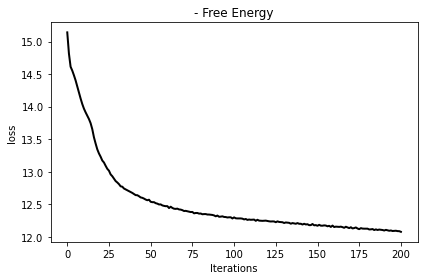

In [99]:
plot_loss(rpm, offset=0)

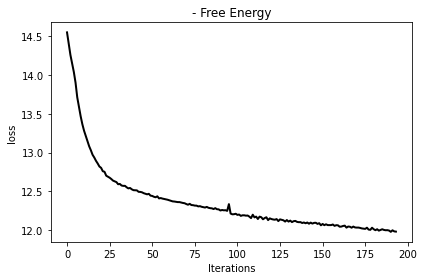

In [95]:
plot_loss(rpm, offset=7)

## Latent Distribution Embeddings of test images

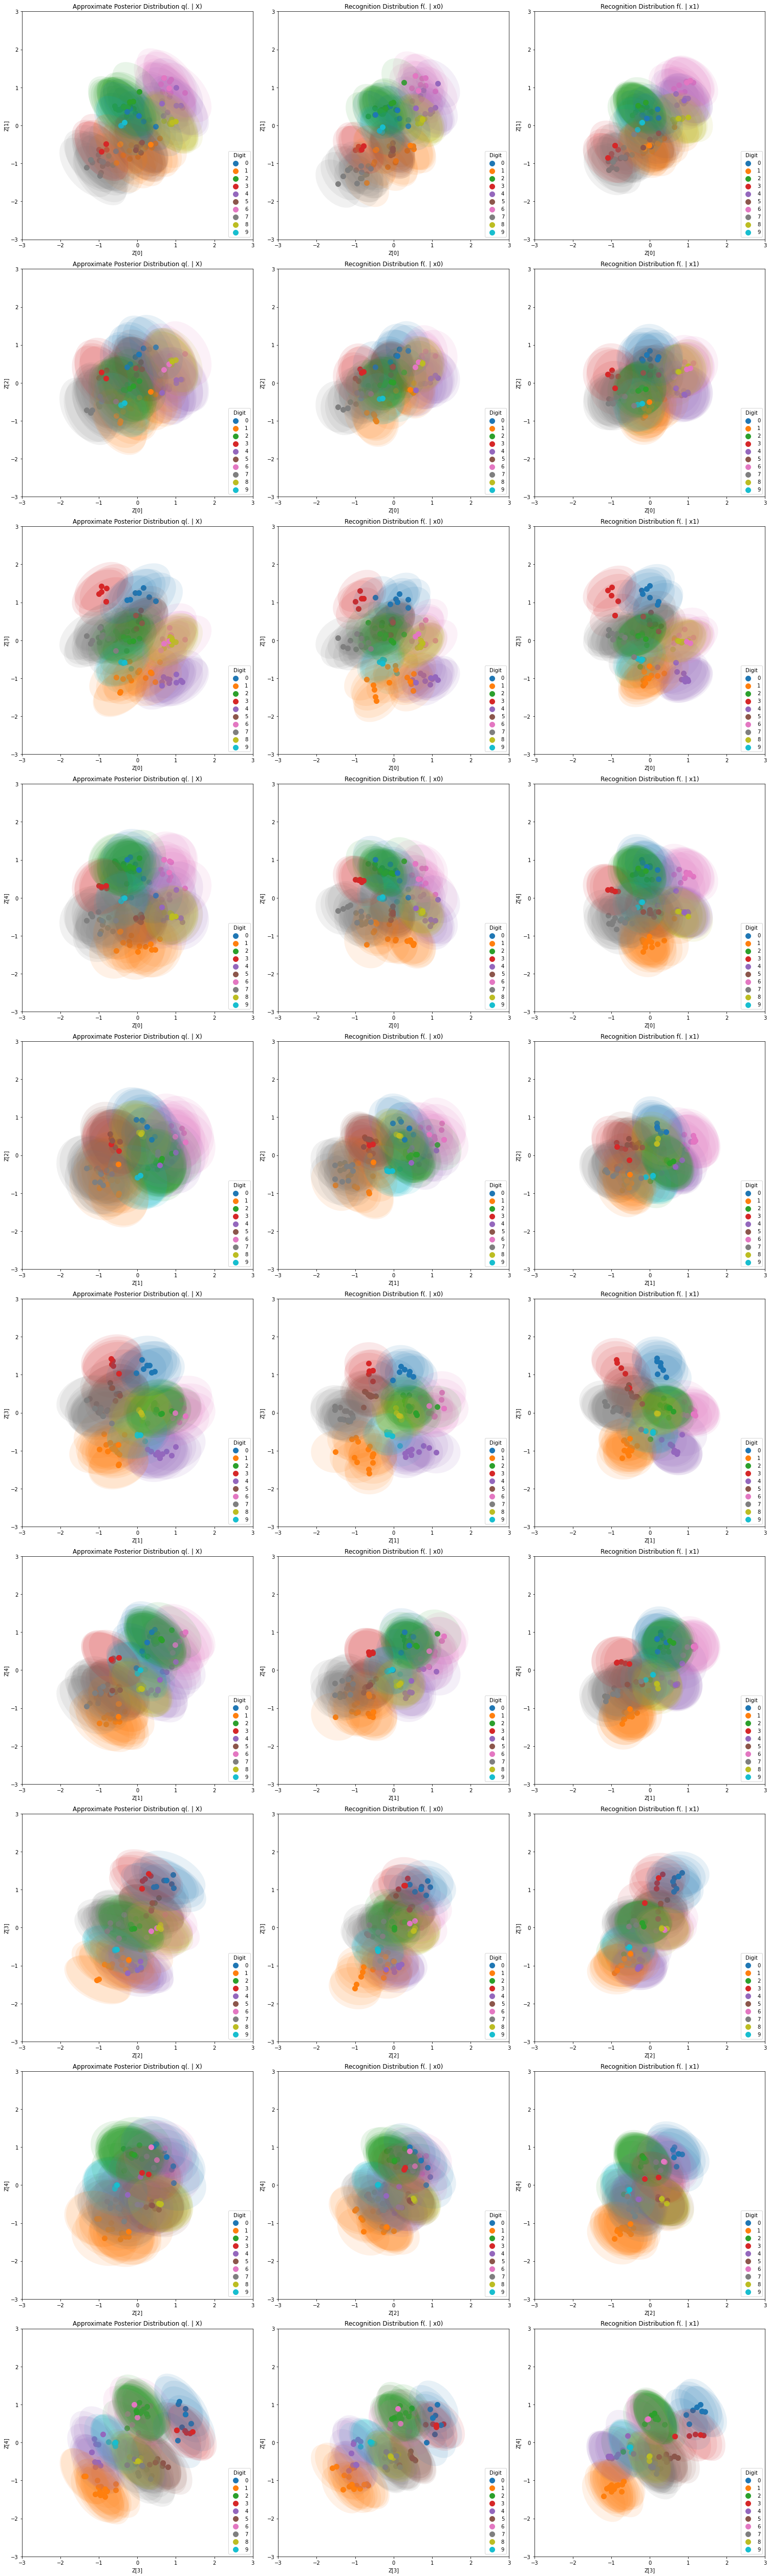

In [100]:
# Forward test data
import utils_process

dim_latent = rpm.dim_latent
heigh = int(dim_latent * (dim_latent - 1) / 2)
width = rpm.num_factors + 1
plt.figure(figsize=(width * 7, heigh * 7))  


for J in range(-1, rpm.num_factors):

    #J = 0
    qdist, fdist = rpm.get_posteriors(obs_test)

    if J == -1:
        mean, vari = qdist.mean_covariance()
        title_str = 'Approximate Posterior Distribution q(. | X)'
    else:
        mean, vari = fdist.mean_covariance()
        mean = mean[J]
        vari = vari[J]
        title_str = 'Recognition Distribution f(. | x' + str(J) + ')'

    mean = mean.detach().clone().cpu().numpy()
    vari = vari.detach().clone().cpu().numpy()


    # Plot testing Data
    subset = 100
    xx = mean[:subset]
    zz = vari[:subset]
    yy = test_labels[:subset, J]
    cmap = plt.get_cmap("tab10")
    
    
    xmaxmin = np.abs(xx).max() + 0.5 * np.sqrt(zz.diagonal(axis1= -1, axis2=-2).max())
    
    compt = 0
    for uu in range(dim_latent -1):
        for vv in range(uu+1, dim_latent):
            offset = width * compt 
            compt += 1
            
            ax = plt.subplot(heigh, width, J + 2 + offset)
            for ii in range(subset):
                y0 = int(yy[ii].numpy())
                x0 = xx[ii]
                z0 = zz[ii]
                plt.scatter(x0[uu], x0[vv], s=100, color=cmap(y0))
                utils_process.confidence_ellipse(x0[[uu, vv]], z0[[uu, vv]][:, [uu, vv]], ax, n_std=1.0, facecolor=cmap(y0), alpha=0.1)
                
            for ii in np.unique(yy):
                y0 = yy[np.where(yy == ii)]
                x0 = xx[np.where(yy == ii)]
                plt.scatter(x0[0, uu], x0[0, vv], s=100, label=str(int(ii)), color=cmap(int(y0[0].numpy())))

            plt.legend(title = 'Digit', loc= 'lower right')
            plt.xlabel('Z[' + str(uu) + ']')
            plt.ylabel('Z[' + str(vv) + ']')
            plt.title(title_str)
            xmaxmin = 3
            plt.xlim([-xmaxmin, xmaxmin])
            plt.ylim([-xmaxmin, xmaxmin])
            plt.tight_layout()

In [91]:
J

1

In [101]:
from flexible_multivariate_normal import FlexibleMultivariateNormal

qmean, qvar = qdist.mean_covariance()
fmean, fvar = fdist.mean_covariance()
n1, n2 = [xx.clone().detach() for xx in rpm.forwarded_prior]
pmean, pvar = FlexibleMultivariateNormal(n1, n2, init_cholesky=False, init_natural=True, store_suff_stat_mean=True).mean_covariance()
pmean = pmean.cpu().numpy()
pvar = pvar.cpu().numpy()



In [102]:
print(fvar[:, 0].diagonal(dim1=-1, dim2= -2))
print('')
print(qvar[0].diagonal(dim1=-1, dim2= -2))

tensor([[0.3417, 0.4033, 0.4597, 0.3077, 0.3947],
        [0.4212, 0.4330, 0.5019, 0.3212, 0.4564]], device='cuda:0')

tensor([0.4901, 0.6113, 0.7217, 0.4039, 0.5436], device='cuda:0')
